# Base Model Componenets


## Imports

In [1]:
!pip install torchvision
from torchvision import datasets
from torchvision import transforms
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics.cluster import normalized_mutual_info_score

## Function to show images



In [2]:
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')


## Function to regenerate an image from a given image

In [3]:
def plot_reconstruction(model, n=24):
    x,_ = next(iter(data_loader))
    x = x[:n,:,:,:].to(device)
    try:
        out, _, _, log_p = model(x.view(-1, image_size))
    except:
        out, _, _ = model(x.view(-1, image_size))
    x_concat = torch.cat([x.view(-1, 1, 28, 28), out.view(-1, 1, 28, 28)], dim=3)
    out_grid = torchvision.utils.make_grid(x_concat).cpu().data
    show(out_grid)


## Function to generate an image from an arbitary distribution.

In [4]:
def plot_generation(model, n=24):
    with torch.no_grad():
        z = torch.randn(n, z_dim).to(device)
        out = model.decode(z).view(-1, 1, 28, 28)

    out_grid = torchvision.utils.make_grid(out).cpu()
    show(out_grid)

## Configuretions



In [5]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create a directory if not exists
sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

## Dataset Loading

In [6]:
# Specify data directory
data_dir = 'data'

# Fashion-MNIST dataset
dataset  = datasets.FashionMNIST(root=data_dir, train=True, download=True,
                                  transform=transforms.ToTensor())

test_dataset = datasets.FashionMNIST(root=data_dir, train=False, download=True,
                                  transform=transforms.ToTensor())

# Data loaders (adjust batch size as needed)
data_loader  = torch.utils.data.DataLoader(dataset=dataset , batch_size=128, shuffle=True)
test_loader  = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=10, shuffle=False)

# Now you have access to the Fashion-MNIST dataset through train_loader and test_loader

## VAE Architecture

In [7]:

# VAE model
class VAE(nn.Module):
    def __init__(self, image_size=784, h_dim=400, z_dim=20):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(image_size, h_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(h_dim, z_dim)
        self.fc4 = nn.Linear(z_dim, h_dim)
        self.fc5 = nn.Linear(h_dim, image_size)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2(h), self.fc3(h)

    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc4(z))
        return torch.sigmoid(self.fc5(h))

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var


## Create VAE model

In [8]:
# Hyper-parameters
image_size = 784
h_dim = 400
z_dim = 20
num_epochs = 15
learning_rate = 1e-3

model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Train the model

Modified to calculate loss of each epoch, but accumulating the loss over all batches of an epoch

In [9]:
from typing_extensions import final
# Start training
# Added few lines to store loss for later comparision
stored_loss_3layer = None
for epoch in range(num_epochs):
    running_loss = 0

    for i, (x, _) in enumerate(data_loader):
        # Forward pass
        x = x.to(device).view(-1, image_size)
        x_reconst, mu, log_var = model(x)

        # Compute reconstruction loss and kl divergence
        # For KL divergence between Gaussians, see Appendix B in VAE paper or (Doersch, 2016):
        # https://arxiv.org/abs/1606.05908
        reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

        # Backprop and optimize
        loss = reconst_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if (i+1) % 10 == 0:
            print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item()/len(x), kl_div.item()/len(x)))
    # Calculate loss for each epoch and store
    stored_loss_3layer = running_loss / len(data_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {stored_loss_3layer:.4f}")
model_3layer = model

Epoch[1/15], Step [10/469], Reconst Loss: 409.8803, KL Div: 8.4459
Epoch[1/15], Step [20/469], Reconst Loss: 359.6008, KL Div: 11.5454
Epoch[1/15], Step [30/469], Reconst Loss: 327.0454, KL Div: 12.3341
Epoch[1/15], Step [40/469], Reconst Loss: 310.8976, KL Div: 13.2036
Epoch[1/15], Step [50/469], Reconst Loss: 297.1580, KL Div: 12.7976
Epoch[1/15], Step [60/469], Reconst Loss: 295.3097, KL Div: 10.6137
Epoch[1/15], Step [70/469], Reconst Loss: 274.8578, KL Div: 14.1156
Epoch[1/15], Step [80/469], Reconst Loss: 287.5834, KL Div: 12.5539
Epoch[1/15], Step [90/469], Reconst Loss: 292.9351, KL Div: 14.2309
Epoch[1/15], Step [100/469], Reconst Loss: 285.3587, KL Div: 12.1276
Epoch[1/15], Step [110/469], Reconst Loss: 287.1570, KL Div: 14.7900
Epoch[1/15], Step [120/469], Reconst Loss: 265.1456, KL Div: 13.9054
Epoch[1/15], Step [130/469], Reconst Loss: 269.6523, KL Div: 15.1733
Epoch[1/15], Step [140/469], Reconst Loss: 259.4571, KL Div: 13.9088
Epoch[1/15], Step [150/469], Reconst Loss: 2

## Show generation

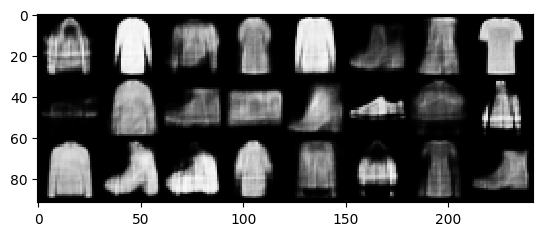

In [10]:
plot_generation(model)

## Show Reconstraction

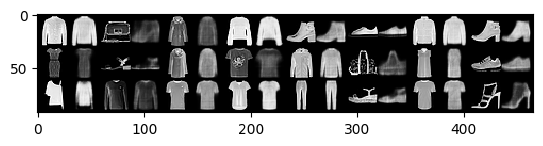

In [11]:
plot_reconstruction(model)

# Tasks

## a.
### Change the base three layer model into a four layer model

In this task you need to modify the VAE class and convert it into a four layer class

# 5-Layer VAE

A 5-layer VAE model for learning compressed data representations and generating samples.

Encoder maps input to latent space, generating mean (fc4_mu) and log-variance (fc4_logvar)

Reparameterization samples from latent space with added noise

Decoder reconstructs input through layers fc5 to fc8

## Parameters
image_size: Input dimension (e.g., 784)
h_dim1, h_dim2, h_dim3: Hidden layer sizes
z_dim: Latent dimension


In [12]:
# 5 layer VAE class
class VAE_5Layer(nn.Module):
    def __init__(self, image_size=784, h_dim1=400, h_dim2=200, h_dim3=100, z_dim=20):
        super(VAE_5Layer, self).__init__()
        # Encoder layers
        self.fc1 = nn.Linear(image_size, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc3 = nn.Linear(h_dim2, h_dim3)
        self.fc4_mu = nn.Linear(h_dim3, z_dim)
        self.fc4_logvar = nn.Linear(h_dim3, z_dim)

        # Decoder layers
        self.fc5 = nn.Linear(z_dim, h_dim3)
        self.fc6 = nn.Linear(h_dim3, h_dim2)
        self.fc7 = nn.Linear(h_dim2, h_dim1)
        self.fc8 = nn.Linear(h_dim1, image_size)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        h3 = F.relu(self.fc3(h2))
        return self.fc4_mu(h3), self.fc4_logvar(h3)

    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var / 2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc5(z))
        h4 = F.relu(self.fc6(h3))
        h5 = F.relu(self.fc7(h4))
        return torch.sigmoid(self.fc8(h5))

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var

# Create New Model

Defines hyper-parameters and initializes 5-layer model with Adam optimizer.


In [13]:
# Create new model
# Hyper-parameters
image_size = 784
h_dim1, h_dim2, h_dim3 = 400, 200, 100
z_dim = 20
num_epochs = 15
learning_rate = 1e-3

# Initialize the 5-layer model, optimizer, and loss function
model_5layer = VAE_5Layer(image_size=image_size, h_dim1=h_dim1, h_dim2=h_dim2, h_dim3=h_dim3, z_dim=z_dim).to(device)
optimizer_5layer = torch.optim.Adam(model_5layer.parameters(), lr=learning_rate)

# Train New Model

Defines early stopping parameters: patience set to 3, best_loss initialized to infinity, and a counter for epochs without improvement.

For each epoch:
- Sets model to training mode
- Calculates reconstruction and KL divergence losses
- Accumulates and prints loss every 10 steps

Performs backpropagation, optimization, and checks for early stopping if no improvement in loss. Training stops when the number of epochs without improvement reaches the patience threshold.

Final loss of 5-layer VAE is saved as final_loss_5layer.


In [14]:
# Train new model
# Early stopping parameters
patience = 3  # Stop the training if no improvement after 3 epochs
best_loss = float("inf")
epochs_without_improvement = 0

for epoch in range(num_epochs):
    model_5layer.train()
    running_loss = 0  # Total loss for the epoch

    for i, (x, _) in enumerate(data_loader):
        x = x.to(device).view(-1, image_size)
        x_reconst, mu, log_var = model_5layer(x)

        # Calculate Reconstruction + KL Divergence losses
        reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
        kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

        # Total loss
        loss = reconst_loss + kl_div
        running_loss += loss.item()  # Accumulate loss for the epoch
        if (i+1) % 10 == 0:
            print("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item()/len(x), kl_div.item()/len(x)))

        # Backpropagation and optimization
        optimizer_5layer.zero_grad()
        loss.backward()
        optimizer_5layer.step()

    # Calculate epoch loss
    epoch_loss = running_loss / len(data_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    # Check for early stopping
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        epochs_without_improvement = 0  # Reset the counter if improvement exists
    else:
        epochs_without_improvement += 1  # Increment the counter if no improvement exists

    if epochs_without_improvement >= patience:
        print("Early stopping as no improvement")
        break

# Save final loss of 5 layer VAE
final_loss_5layer = best_loss

Epoch[1/15], Step [10/469], Reconst Loss: 433.4102, KL Div: 5.3284
Epoch[1/15], Step [20/469], Reconst Loss: 399.3588, KL Div: 0.0438
Epoch[1/15], Step [30/469], Reconst Loss: 379.4254, KL Div: 0.1387
Epoch[1/15], Step [40/469], Reconst Loss: 380.1939, KL Div: 2.6476
Epoch[1/15], Step [50/469], Reconst Loss: 383.3242, KL Div: 1.7282
Epoch[1/15], Step [60/469], Reconst Loss: 371.4664, KL Div: 2.2908
Epoch[1/15], Step [70/469], Reconst Loss: 365.2347, KL Div: 4.2480
Epoch[1/15], Step [80/469], Reconst Loss: 345.6154, KL Div: 5.1882
Epoch[1/15], Step [90/469], Reconst Loss: 316.6001, KL Div: 7.7861
Epoch[1/15], Step [100/469], Reconst Loss: 291.9363, KL Div: 8.9332
Epoch[1/15], Step [110/469], Reconst Loss: 305.8613, KL Div: 9.2993
Epoch[1/15], Step [120/469], Reconst Loss: 282.9518, KL Div: 10.4603
Epoch[1/15], Step [130/469], Reconst Loss: 281.1432, KL Div: 10.8184
Epoch[1/15], Step [140/469], Reconst Loss: 285.1371, KL Div: 10.0421
Epoch[1/15], Step [150/469], Reconst Loss: 274.6990, K

# Compare Final Loss of Old and New Models

Displays the final loss values of the fully trained models:
- Old model (3-layer VAE): stored_loss_3layer
- New model (5-layer VAE): final_loss_5layer


In [15]:
# Compare the final loss of the fully trained old model and the new model
print("Final Loss of Old Model (3-layer VAE):", stored_loss_3layer)
print("Final Loss of New Model (5-layer VAE):", final_loss_5layer)

Final Loss of Old Model (3-layer VAE): 241.24258818359374
Final Loss of New Model (5-layer VAE): 242.97938125


# Compare Reconstructed Images from 3-Layer and 5-Layer Models

Displays reconstructed images from both models for visual comparison:
- 3-layer model using plot_reconstruction(model)
- 5-layer model using plot_reconstruction(model_5layer)


Reconstructed images (3-layer model):


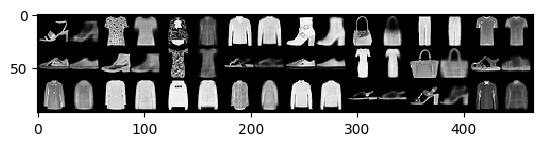

Reconstructed images (5-layer model):


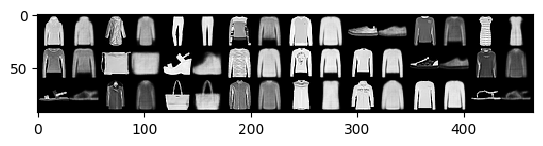

In [16]:
# Compare the reconstructed images from the two models
print("Reconstructed images (3-layer model):")
plot_reconstruction(model)
plt.show()

print("Reconstructed images (5-layer model):")
plot_reconstruction(model_5layer)
plt.show()

# Compare Generated Images from 3-Layer and 5-Layer Models

Displays generated images from both models for visual comparison

- 3-layer model using plot_generation(model)
- 5-layer model using plot_generation(model_5layer)


Generated images (3-layer model):


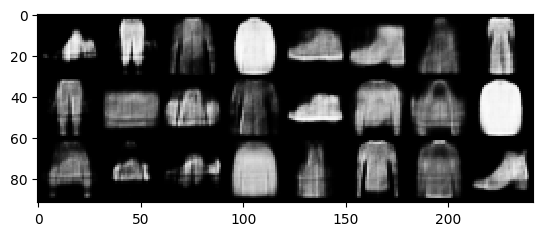

Generated images (5-layer model):


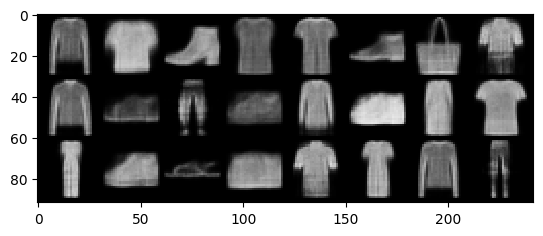

In [17]:
# Compare generate images from the two models
print("Generated images (3-layer model):")
plot_generation(model)
plt.show()

print("Generated images (5-layer model):")
plot_generation(model_5layer)
plt.show()

# Output Comparision Descripton

The 3 layer model has lower loss which is 241.2, early stopping is also implemented in 5 layer model. The 5 layer model has a loss around 243.

The visuals also show that the 3 layer model generates and reconstructs better because it learnt patterns.

The 5 layer model has more loss because overfitting is possible in it.

# Visual Comparision

The 5 layer model has lesser loss and slightly better quality and generated and reconstructed images. Few simple images are captured better in 3 layer model. Most images appear better in 5 layer model as it captures more complicated features

## b.
### Change the layers

In this experiment you will change the layers of the VAE using different combinations and compare the results

# Create Different 3-Layer VAE Models with Various h_dim and z_dim

Defines configurations for h_dim and z_dim values and initializes a model for each configuration. Configurations include different combinations such as (400, 20), (200, 50), (400, 70), etc., with each model stored in the models dictionary.


In [18]:
# Create different 3 layer VAE models with different h-dim and z-dim
# Define configurations for h_dim and z_dim
configurations = [(400, 20), (200, 50), (400, 70), (300, 30), (250, 80), (300, 5)]
models = {}

# Create a model for each configuration
for h_dim, z_dim in configurations:
    models[(h_dim, z_dim)] = VAE(image_size=784, h_dim=h_dim, z_dim=z_dim).to(device)

# Train All Models

Training parameters include num_epochs set to 15, learning_rate set to 1e-3, and early stopping patience set to 3.

Each model configuration in models is trained as follows:
- Optimizer is initialized, and best_loss tracking begins
- For each epoch, the model is trained with reconstruction and KL divergence loss calculated, followed by backpropagation and weight updates
- If no improvement in loss is observed for 3 consecutive epochs, early stopping is triggered

Final results, including the trained model and final loss for each (h_dim, z_dim) configuration, are stored in the results dictionary.


In [19]:
# Train all models
# Training parameters
num_epochs = 15
learning_rate = 1e-3
patience = 3  # Early stopping if no improvement is see after 3 epochs

# Dictionary to store final losses and trained models
results = {}

# Train each model
for (h_dim, z_dim), model in models.items():
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    best_loss = float("inf")
    epochs_without_improvement = 0

    print(f"\nTraining model with h_dim={h_dim}, z_dim={z_dim}")

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0

        for i, (x, _) in enumerate(data_loader):
            x = x.to(device).view(-1, 784)
            x_reconst, mu, log_var = model(x)

            # Calculate Reconstruction + KL Divergence losses
            reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
            kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

            # Total loss
            loss = reconst_loss + kl_div
            running_loss += loss.item()

            # Backpropagation and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Calculate average loss for the epoch
        epoch_loss = running_loss / len(data_loader.dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

        # Early stopping if no improvement in loss
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print("Early stopping as no improvement is seen.")
            break

    # Store results
    results[(h_dim, z_dim)] = {"model": model, "final_loss": best_loss}


Training model with h_dim=400, z_dim=20
Epoch [1/15], Loss: 285.9074
Epoch [2/15], Loss: 257.8045
Epoch [3/15], Loss: 251.5100
Epoch [4/15], Loss: 248.4038
Epoch [5/15], Loss: 246.6670
Epoch [6/15], Loss: 245.4332
Epoch [7/15], Loss: 244.6677
Epoch [8/15], Loss: 244.0076
Epoch [9/15], Loss: 243.4884
Epoch [10/15], Loss: 242.9974
Epoch [11/15], Loss: 242.6731
Epoch [12/15], Loss: 242.3416
Epoch [13/15], Loss: 242.0119
Epoch [14/15], Loss: 241.8123
Epoch [15/15], Loss: 241.5250

Training model with h_dim=200, z_dim=50
Epoch [1/15], Loss: 300.1212
Epoch [2/15], Loss: 266.8132
Epoch [3/15], Loss: 257.5566
Epoch [4/15], Loss: 252.4897
Epoch [5/15], Loss: 249.6285
Epoch [6/15], Loss: 247.8260
Epoch [7/15], Loss: 246.6458
Epoch [8/15], Loss: 245.7933
Epoch [9/15], Loss: 245.1280
Epoch [10/15], Loss: 244.5987
Epoch [11/15], Loss: 244.1608
Epoch [12/15], Loss: 243.7961
Epoch [13/15], Loss: 243.4588
Epoch [14/15], Loss: 243.1801
Epoch [15/15], Loss: 242.9503

Training model with h_dim=400, z_di

# Compare Models Based on Optimal Loss

Displays the final optimal loss for each model configuration

Optimal Loss for Each Configuration:
- For each (h_dim, z_dim) combination, the final loss value is printed to compare model performance


In [20]:
# Compare the models based on their optimal loss
# Final loss for each configuration
print("\nOptimal Loss for Each Configuration:")
for (h_dim, z_dim), result in results.items():
    print(f"h_dim={h_dim}, z_dim={z_dim}: Final Loss = {result['final_loss']:.4f}")


Optimal Loss for Each Configuration:
h_dim=400, z_dim=20: Final Loss = 241.5250
h_dim=200, z_dim=50: Final Loss = 242.9503
h_dim=400, z_dim=70: Final Loss = 241.4526
h_dim=300, z_dim=30: Final Loss = 241.8083
h_dim=250, z_dim=80: Final Loss = 242.3263
h_dim=300, z_dim=5: Final Loss = 244.0852


# Compare Models Based on Generated Images (Visual Inspection)

Generated Images for Each Configuration:
- For each (h_dim, z_dim) combination, displays generated images for visual comparison of model performance



Generated Images for Each Configuration:

Generated images for model with h_dim=400, z_dim=20:


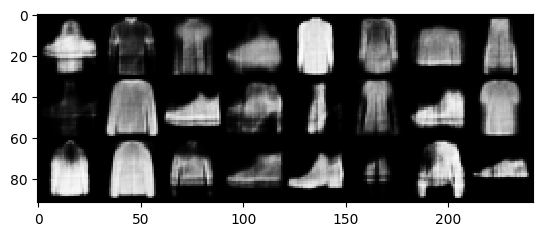


Generated images for model with h_dim=200, z_dim=50:


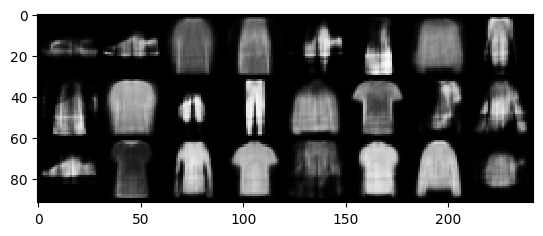


Generated images for model with h_dim=400, z_dim=70:


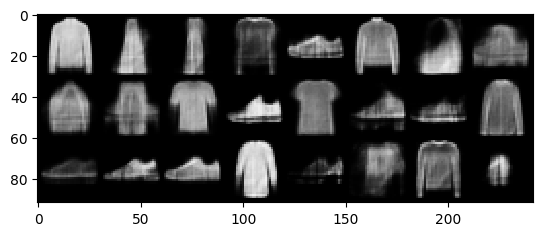


Generated images for model with h_dim=300, z_dim=30:


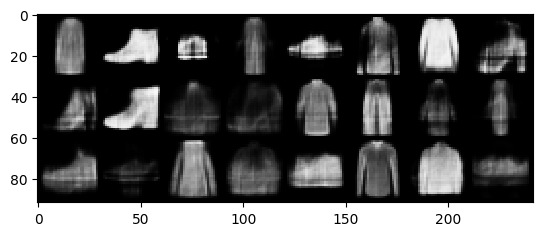


Generated images for model with h_dim=250, z_dim=80:


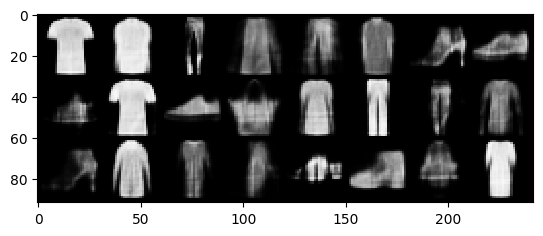


Generated images for model with h_dim=300, z_dim=5:


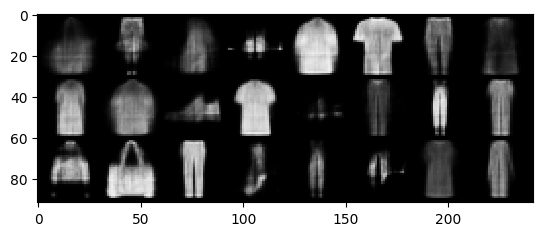

In [21]:
# Compare models based on their generated images (visual inspection)
print("\nGenerated Images for Each Configuration:")
for (h_dim, z_dim), result in results.items():
    print(f"\nGenerated images for model with h_dim={h_dim}, z_dim={z_dim}:")
    plot_generation(result["model"])
    plt.show()

# Compare Models Based on Reconstructed Images (Visual Inspection)

Reconstructed Images for Each Configuration:
- For each (h_dim, z_dim) combination, displays reconstructed images to visually assess model performance



Reconstructed Images for Each Configuration:

Reconstructed images for model with h_dim=400, z_dim=20:


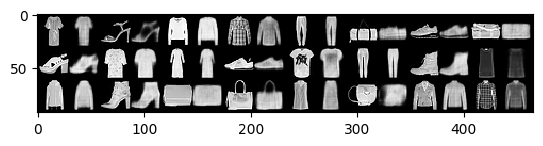


Reconstructed images for model with h_dim=200, z_dim=50:


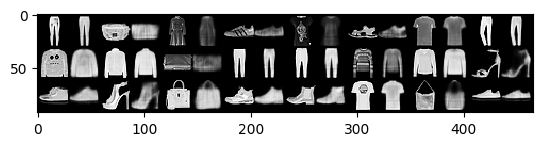


Reconstructed images for model with h_dim=400, z_dim=70:


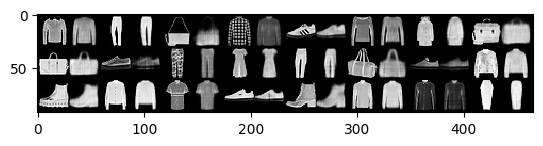


Reconstructed images for model with h_dim=300, z_dim=30:


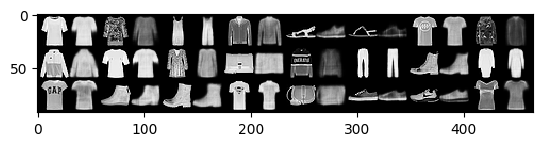


Reconstructed images for model with h_dim=250, z_dim=80:


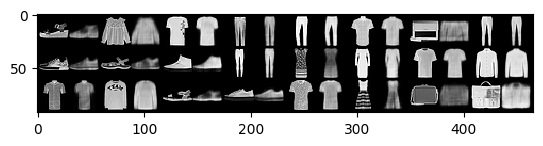


Reconstructed images for model with h_dim=300, z_dim=5:


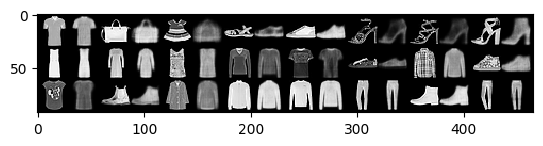

In [22]:
# Compare models based on their regenerated images (visual inspection)
print("\nReconstructed Images for Each Configuration:")
for (h_dim, z_dim), result in results.items():
    print(f"\nReconstructed images for model with h_dim={h_dim}, z_dim={z_dim}:")
    plot_reconstruction(result["model"])
    plt.show()

# Output Comparison Description

From the loss comparison across different models with varying hidden dimensions (h_dim) and latent dimensions (z_dim), we can observe the following:
- The final loss values vary depending on the chosen h_dim and z_dim configurations.
- Lower loss values typically indicate better reconstruction performance, as the model can capture the data distribution more effectively.
- Comparing the losses helps identify which configurations offer the most efficient compression (smaller z_dim) while maintaining low reconstruction loss.

The optimal configuration can be determined based on the lowest final loss, balancing both efficient compression (smaller z_dim) and high reconstruction quality.

# Visual Comparison Description

The generated and reconstructed images provide visual insights into model performance for each configuration:
- Generated images show how well each model can produce realistic data samples from the latent space.
- Reconstructed images highlight the model's ability to retain input features after encoding and decoding.

From the comparison:
- Higher values of h_dim and z_dim generally improve detail and clarity in both generated and reconstructed images, as they allow for more complex representations.
- Lower z_dim values tend to result in blurrier or less distinct outputs, as the model struggles to represent the input with fewer latent dimensions.

## c.
### Create a Normal Autoencoder

In this experiment you will convert the current model into an autoencoder

# 3-Layer Autoencoder

3-layer Autoencoder class, modified from a Variational Autoencoder (VAE) to a standard autoencoder structure.

Encoder compresses the input data down to a smaller latent dimension (z_dim) using two layers (fc1 and fc2), without the probabilistic layers found in a VAE

Decoder expands the latent representation back to the original input size through two layers (fc3 and fc4)

Forward pass combines encoding and decoding to output a reconstructed version of the input

In [23]:
# Convert the VAE class into an 3layer autoencoder
class Autoencoder(nn.Module):
    def __init__(self, image_size=784, h_dim=400, z_dim=20):
        super(Autoencoder, self).__init__()
        # Encoder layers
        self.fc1 = nn.Linear(image_size, h_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)  # Single latent layer, no mean/variance layers

        # Decoder layers
        self.fc3 = nn.Linear(z_dim, h_dim)
        self.fc4 = nn.Linear(h_dim, image_size)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2(h)  # Single layer encoding

    def decode(self, z):
        h = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h))

    def forward(self, x):
        z = self.encode(x)
        x_reconst = self.decode(z)
        return x_reconst

# Create the Autoencoder Model

Defines model parameters

Initializes the autoencoder model and the Adam optimizer.


In [24]:
# Create the autoenocder model
# Hyper-parameters
image_size = 784
h_dim = 400
z_dim = 20
num_epochs = 15
learning_rate = 1e-3
patience = 3  # Early stopping patience

# Initialize the 3-layer autoencoder model and optimizer
model_autoencoder = Autoencoder(image_size=image_size, h_dim=h_dim, z_dim=z_dim).to(device)
optimizer_autoencoder = torch.optim.Adam(model_autoencoder.parameters(), lr=learning_rate)

# Train the Autoencoder

Defines training procedure for the autoencoder, using reconstruction loss only (no KL divergence), with early stopping if no improvement for 3 epochs.

For each epoch:
- Sets model to training mode and computes reconstruction loss per batch
- Prints reconstruction loss every 10 steps and performs backpropagation with the Adam optimizer
- Calculates average loss for the epoch and triggers early stopping if no improvement is seen

Final loss for the autoencoder is stored as final_loss_autoencoder.


In [25]:
# Change the training procedure to train the auto-enocder
# Training loop for the 3-layer normal autoencoder
best_loss = float("inf")
epochs_without_improvement = 0

for epoch in range(num_epochs):
    model_autoencoder.train()
    running_loss = 0

    for i, (x, _) in enumerate(data_loader):
        x = x.to(device).view(-1, image_size)
        x_reconst = model_autoencoder(x)

        # Only reconstruction loss for normal autoencoder
        reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')

        # Backpropagation and optimization
        optimizer_autoencoder.zero_grad()
        reconst_loss.backward()
        optimizer_autoencoder.step()

        running_loss += reconst_loss.item()

    # Calculate average loss for the epoch
    epoch_loss = running_loss / len(data_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    # Early stopping
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print("Early stopping triggered.")
        break

# Store final loss for comparison
final_loss_autoencoder = best_loss

Epoch [1/15], Loss: 254.5136
Epoch [2/15], Loss: 224.9578
Epoch [3/15], Loss: 220.5735
Epoch [4/15], Loss: 218.2214
Epoch [5/15], Loss: 216.7794
Epoch [6/15], Loss: 215.8031
Epoch [7/15], Loss: 215.0207
Epoch [8/15], Loss: 214.4321
Epoch [9/15], Loss: 213.9473
Epoch [10/15], Loss: 213.5456
Epoch [11/15], Loss: 213.2078
Epoch [12/15], Loss: 212.9034
Epoch [13/15], Loss: 212.6572
Epoch [14/15], Loss: 212.4196
Epoch [15/15], Loss: 212.2242


# Compare Models Based on Loss

Comparing final loss values for the two models:
- Final Loss of 3-Layer VAE Model: final_loss_3layer
- Final Loss of 3-Layer Normal Autoencoder: final_loss_autoencoder


In [26]:
# Compare the models based on their loss
print("Final Loss of 3-Layer VAE Model:", stored_loss_3layer)  # Replace with recorded final loss of 3-layer VAE
print("Final Loss of 3-Layer Normal Autoencoder:", final_loss_autoencoder)

Final Loss of 3-Layer VAE Model: 241.24258818359374
Final Loss of 3-Layer Normal Autoencoder: 212.2241541015625


# Compare Models Based on Generated Images (Visual Inspection)

- Generated images for 3-layer Normal Autoencoder using plot_generation(model_autoencoder)
- Generated images for 3-layer VAE using plot_generation(model_3layer)


Generated images (3-layer Normal Autoencoder):


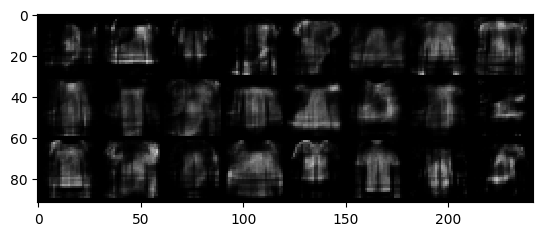

Generated images (3-layer VAE):


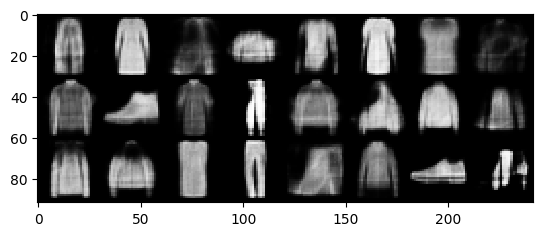

In [27]:
# Compare models based on their generated images (visual inspection)
# Generated images for normal autoencoder
print("Generated images (3-layer Normal Autoencoder):")
plot_generation(model_autoencoder)
plt.show()

# Generated images for 3-layer VAE model
print("Generated images (3-layer VAE):")
plot_generation(model_3layer)
plt.show()

# Compare Models Based on Reconstructed Images (Visual Inspection)

- Reconstructed images for 3-layer Normal Autoencoder using plot_reconstruction_autoencoder(model_autoencoder)
- Reconstructed images for 3-layer VAE using plot_reconstruction(model_3layer)


Reconstructed images (3-layer Normal Autoencoder):


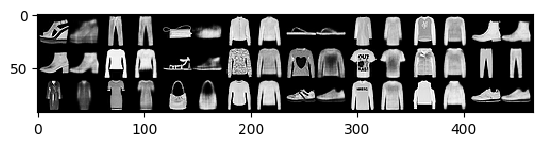

Reconstructed images (3-layer VAE):


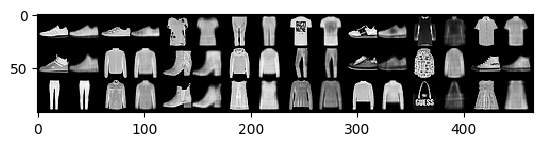

In [28]:
# Compare models based on their regenerated images (visual inspection)

def plot_reconstruction_autoencoder(model, n=24):
    x, _ = next(iter(data_loader))
    x = x[:n, :, :, :].to(device)

    # Forward pass for autoencoder
    out = model(x.view(-1, image_size))

    # Concatenate the original and reconstructed images
    x_concat = torch.cat([x.view(-1, 1, 28, 28), out.view(-1, 1, 28, 28)], dim=3)
    out_grid = torchvision.utils.make_grid(x_concat).cpu().data
    show(out_grid)


# Reconstructed images for normal autoencoder
print("Reconstructed images (3-layer Normal Autoencoder):")
plot_reconstruction_autoencoder(model_autoencoder)
plt.show()

# Reconstructed images for 3-layer VAE model
print("Reconstructed images (3-layer VAE):")
plot_reconstruction(model_3layer)
plt.show()


# Output Comparison Description

When comparing the results from the 3-layer VAE and the 3-layer Normal Autoencoder:

The normal autoencoder has a loss of 212.2, but VAE has a loss of 241.2

- **Generated Images**: The VAE produces clearer and more recognizable images of clothing items. The autoencoder’s images appear more blurred and lack distinct features but their loss is lower which mean normal autoencoder has less overfitting and recognizes patterns well.
- **Reconstructed Images**: The VAE captures more detail and structure in the reconstructed images, making the clothing items look more realistic which might indicate overfitting, while the autoencoder's reconstructions are fuzzier and less defined.

Overall, the autoencoder is a better model due to less loss and efficient patter recognition

# Visual Comparison Description

- **3-Layer Normal Autoencoder**: The images appear soft and blurred, with clothing items not very clearly defined.
- **3-Layer VAE**: The images look sharper and more detailed, with distinct shapes.

In general, the VAE provides clearer, more realistic-looking results in both generated and reconstructed images, but the autoencoder captures patterns better

## References
1. https://github.com/dataflowr/notebooks/blob/master/HW3/VAE_clustering_empty.ipynb